# PIA

### SETUP

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

### Datos

Nota: Del archivo "train", se tomará el 75% de los datos como entrenamiento y el 25% como prueba para poder hacer cross validation con el criterio ROC_AUC en ambos sets.

In [100]:
data = pd.read_csv('train.csv').drop("id", axis=1)
X = data.drop(columns=['engagement'])
y = data['engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [101]:
train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
registros = len(train)
conteo = train['engagement'].value_counts()
positivos = conteo.get(True, 0)
negativos = conteo.get(False, 0)
print(f"Hay {registros} registros en total en los datos de entrenamiento, de los cuales {positivos} tuvieron engagement y {negativos} no lo tuvieron.")


Hay 6929 registros en total en los datos de entrenamiento, de los cuales 661 tuvieron engagement y 6268 no lo tuvieron.


In [116]:
#Estadística Descriptiva de los Datos de Entrenamiento

def stat_desc(data, title_suffix):
    columns_to_analyze = data.columns[:8]
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(columns_to_analyze):
        promedio = data[col].mean()
        minimo = data[col].min()
        maximo = data[col].max()
        desviacion_estandar = data[col].std()
        
        print(f"\n{title_suffix} - Variable: {col}")
        print(f"  Promedio: {promedio:.2f}")
        print(f"  Mínimo: {minimo:.2f}")
        print(f"  Máximo: {maximo:.2f}")
        print(f"  Desviación Estándar: {desviacion_estandar:.2f}")
        
        plt.subplot(2, 4, i + 1)
        plt.boxplot(data[col], 
                    boxprops=dict(linewidth=2, color="#984EA3"), 
                    whiskerprops=dict(linewidth=2, color="#984EA3"), 
                    medianprops=dict(linewidth=2, color='black'), 
                    capprops=dict(linewidth=2, color="#984EA3"), 
                    flierprops=dict(marker='.', color='red', markersize=5, linestyle='none'))
        plt.title(col)
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle(f'Estadística Descriptiva ({title_suffix})', y=1.05,fontsize=12,fontweight="bold")
    plt.show()


Engagement = True - Variable: title_word_count
  Promedio: 7.30
  Mínimo: 1.00
  Máximo: 30.00
  Desviación Estándar: 3.96

Engagement = True - Variable: document_entropy
  Promedio: 7.22
  Mínimo: 0.92
  Máximo: 8.78
  Desviación Estándar: 0.76

Engagement = True - Variable: freshness
  Promedio: 15632.84
  Mínimo: 11410.00
  Máximo: 17430.00
  Desviación Estándar: 1141.27

Engagement = True - Variable: easiness
  Promedio: 81.05
  Mínimo: 28.21
  Máximo: 120.88
  Desviación Estándar: 9.96

Engagement = True - Variable: fraction_stopword_presence
  Promedio: 0.59
  Mínimo: 0.00
  Máximo: 1.00
  Desviación Estándar: 0.06

Engagement = True - Variable: normalization_rate
  Promedio: 0.02
  Mínimo: 0.00
  Máximo: 0.08
  Desviación Estándar: 0.01

Engagement = True - Variable: speaker_speed
  Promedio: 2.40
  Mínimo: 0.02
  Máximo: 40.61
  Desviación Estándar: 2.05

Engagement = True - Variable: silent_period_rate
  Promedio: 0.08
  Mínimo: 0.00
  Máximo: 0.96
  Desviación Estándar: 0.13

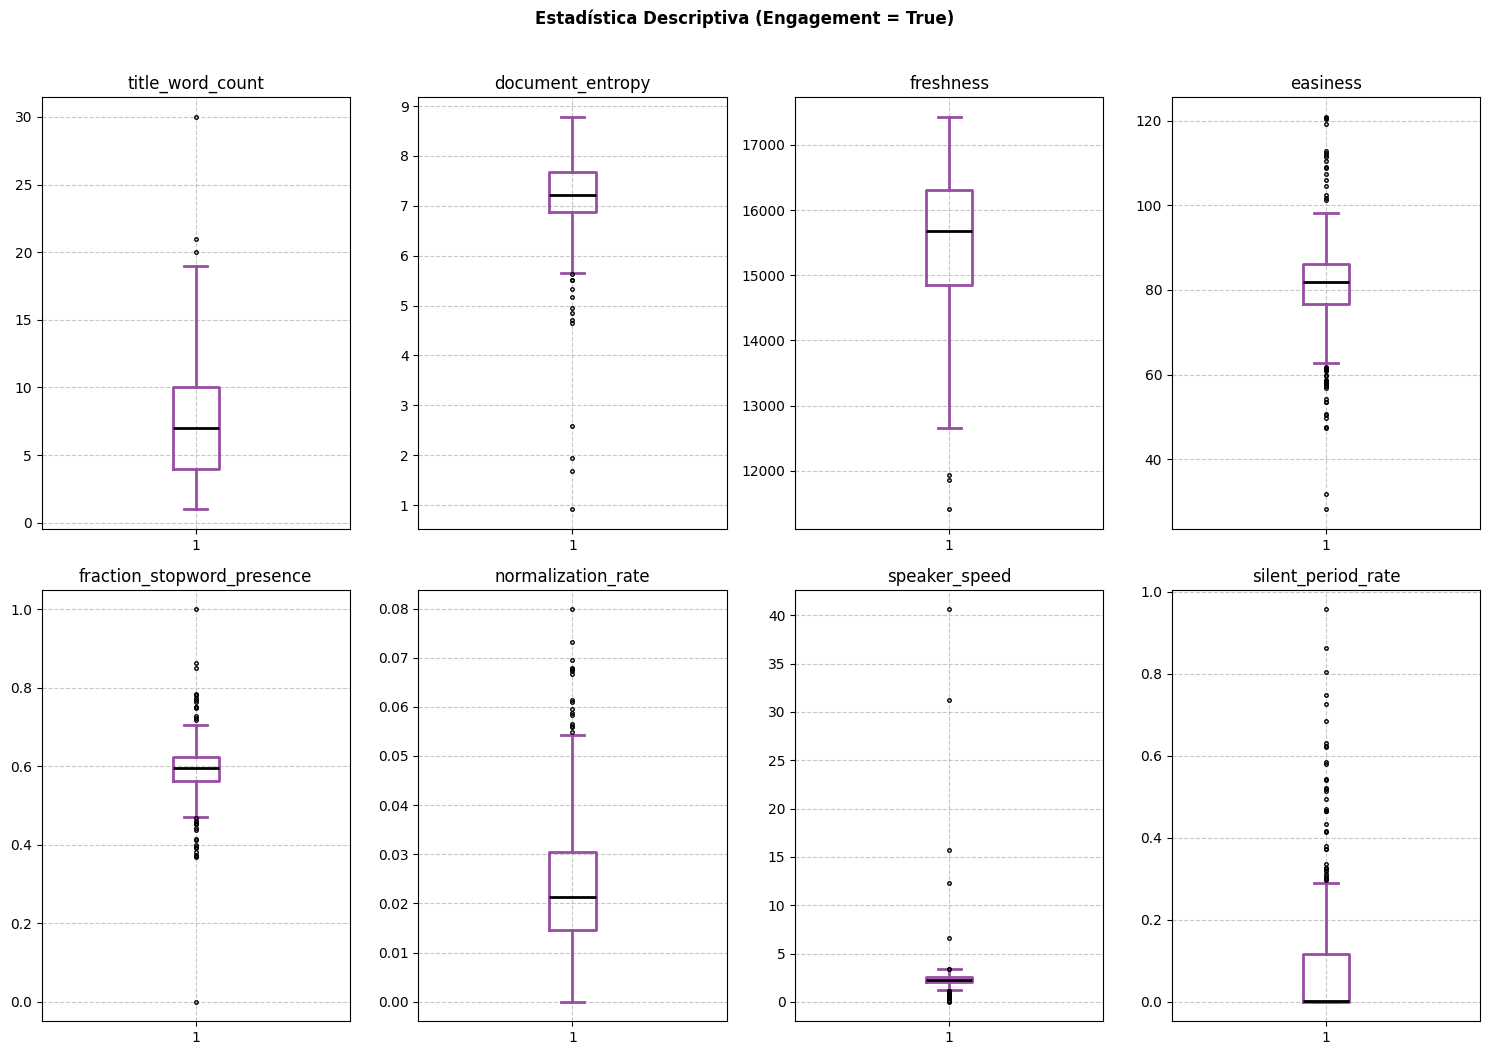


Engagement = False - Variable: title_word_count
  Promedio: 7.71
  Mínimo: 1.00
  Máximo: 33.00
  Desviación Estándar: 3.79

Engagement = False - Variable: document_entropy
  Promedio: 7.86
  Mínimo: 0.00
  Máximo: 9.28
  Desviación Estándar: 0.67

Engagement = False - Variable: freshness
  Promedio: 14733.32
  Mínimo: 10840.00
  Máximo: 17430.00
  Desviación Estándar: 1179.19

Engagement = False - Variable: easiness
  Promedio: 85.14
  Mínimo: 30.84
  Máximo: 122.03
  Desviación Estándar: 8.06

Engagement = False - Variable: fraction_stopword_presence
  Promedio: 0.61
  Mínimo: 0.00
  Máximo: 1.00
  Desviación Estándar: 0.05

Engagement = False - Variable: normalization_rate
  Promedio: 0.02
  Mínimo: 0.00
  Máximo: 0.07
  Desviación Estándar: 0.01

Engagement = False - Variable: speaker_speed
  Promedio: 2.42
  Mínimo: 0.00
  Máximo: 50.85
  Desviación Estándar: 1.61

Engagement = False - Variable: silent_period_rate
  Promedio: 0.15
  Mínimo: 0.00
  Máximo: 1.17
  Desviación Estánd

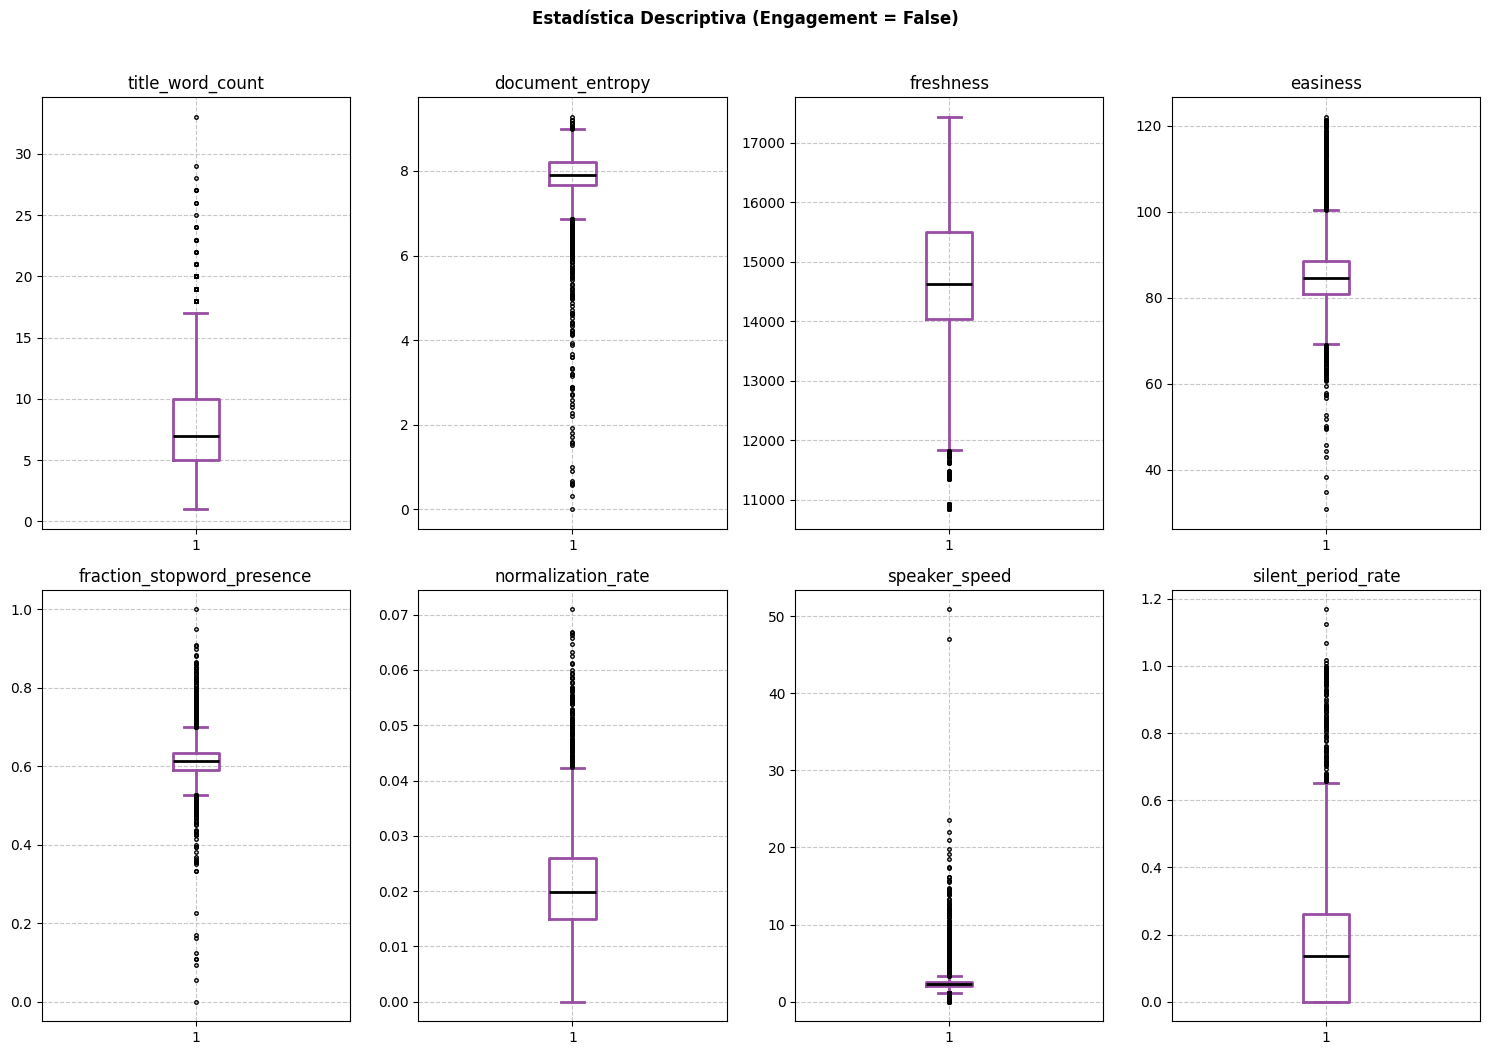

In [117]:
stat_desc(train[train['engagement'] == True], "Engagement = True")
stat_desc(train[train['engagement'] == False], "Engagement = False")

### Entrenamiento

In [104]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), #Estandarización de los datos
    ('classifier', RandomForestClassifier())
])

In [105]:
# Parámetros
param_grid = {
    'classifier__n_estimators': [50, 100, 500], #Cantidad de árboles
    'classifier__max_depth': [None, 10, 20], #Limite de profundidad
    'classifier__min_samples_split': [2, 5, 10] #Cantidad mínima de muestras
}

In [106]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,  # Splits en Cross Validation
    n_jobs=-1 #Ejecuciones en paralelo para disminuir tiempo de respuesta
)

In [107]:
grid_search.fit(X_train, y_train)
print("Mejores parámetros:")
print(grid_search.best_params_)
print("Mejor ROC_AUC:")
print(grid_search.best_score_)

Mejores parámetros:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Mejor ROC_AUC:
0.894093736883768


C:\Users\HP\AppData\Local\Temp\ipykernel_13440\3391190292.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importance_check, palette="plasma")


Text(0.5, 1.0, 'Importancia de las Características para Determinación de "Engagement" ')

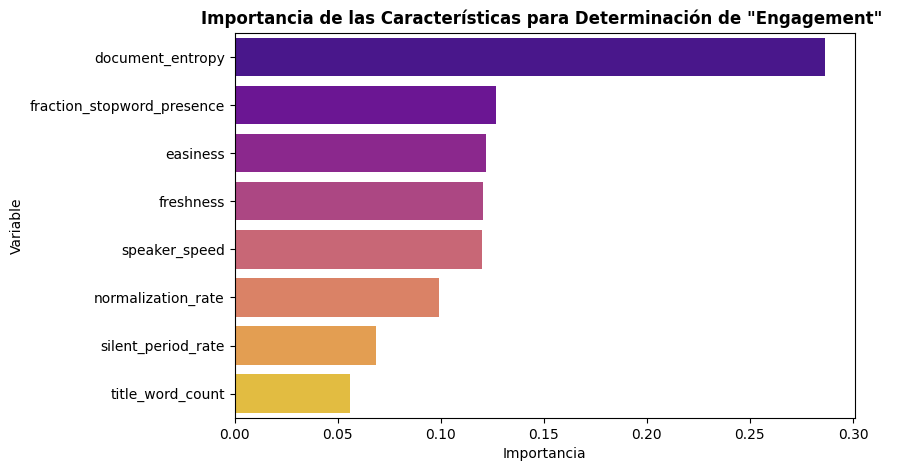

In [108]:
#Checar el peso de cada variable
importances = best_model.named_steps['classifier'].feature_importances_
characteristics = X_train.columns
importance_check = pd.DataFrame({
    'Variable': characteristics,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importancia', y='Variable', data=importance_check, palette="plasma")
plt.title('Importancia de las Características para Determinación de \"Engagement\" ', fontsize=12,fontweight="bold")

### Prueba

In [109]:
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC_AUC para los datos de prueba:")
print(roc_auc)

ROC_AUC para los datos de prueba:
0.8840874916234902


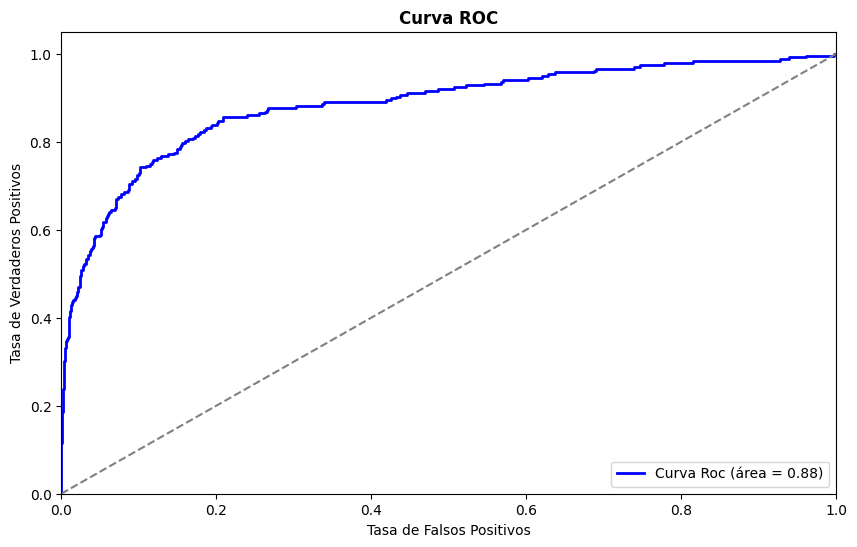

In [115]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva Roc (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC',fontsize=12,fontweight="bold")
plt.legend(loc='lower right')

### Nuevos datos

A partir del modelo, se hará la clasificación de "engagement" en los registros del archivo "test".

In [111]:
new_data = pd.read_csv('test.csv')
new_data_char = new_data.drop("id",axis=1)
new_data_char.head(5)

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
0,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000
1,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000
2,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000
3,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994
4,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000


In [112]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(new_data_char)
probabilities = best_model.predict_proba(new_data_char)[:, 1]

In [113]:
output = new_data.copy()
output['predictions'] = predictions
output['probability'] = probabilities
output.to_excel('predictions.xlsx', index=False)

In [114]:
output

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,predictions,probability
0,9240,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000,False,0.019202
1,9241,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000,False,0.036036
2,9242,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000,False,0.079581
3,9243,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994,True,0.834239
4,9244,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000,False,0.028818
...,...,...,...,...,...,...,...,...,...,...,...
2304,11544,11,7.781813,13920,80.620236,0.611722,0.031276,2.193125,0.194918,False,0.018612
2305,11545,3,7.800766,13990,94.080225,0.654741,0.013967,1.580000,0.338601,False,0.006642
2306,11546,2,8.235828,14280,95.173070,0.618686,0.018486,5.548518,0.369348,False,0.014834
2307,11547,13,6.775492,15900,74.053098,0.560472,0.032448,2.592308,0.005131,True,0.863648
